Worked with:

- Trevor Mathisen
- Viet Nguyen

# Redo MLR HW with Boston dataset

In [60]:
from pandas import read_csv, DataFrame, Series
from pandas.plotting import scatter_matrix
from numpy import set_printoptions, argmax, isnan, nan, mean, random
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sys import modules
if 'tensorflow' in modules:
    del modules['tensorflow']
import tensorflow as tf
print(tf.__version__)

2.19.0


In [61]:
filename = 'boston.csv'
data = read_csv(filename)
set_printoptions(precision=3)
data = data.drop('index', axis=1)
print(data.head(5))
print(data.isnull().sum())
print(data.shape)
# Display unique values in each column
for col in data.columns:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64
(506, 14)
Unique values in 'crim': [6.320e-03 2.731e-02 2.729e-02 3.237e-02 6.905e-02 2.985e-02 8.829e-02
 1.446e-01 2.112e-01 1.700e-01 2.249e-01 1.175e-01 9.378e-02 6.298e-

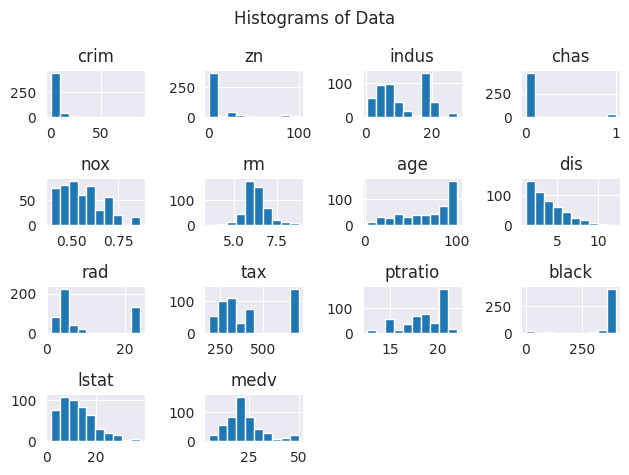

In [62]:
data.hist()
plt.suptitle(f"Histograms of Data")
plt.tight_layout()
plt.show()

In [63]:
features_to_standardize = ['rm', 'ptratio', 'dis', 'nox', 'tax', 'lstat']
features_to_normalize = ['crim', 'zn', 'indus', 'age', 'rad', 'black']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_to_standardize),
        ('norm', Normalizer(), features_to_normalize)
    ],
    remainder='passthrough'
)

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
X = data.drop('medv', axis=1)
y = data['medv']
X_processed = preprocessing_pipeline.fit_transform(X)

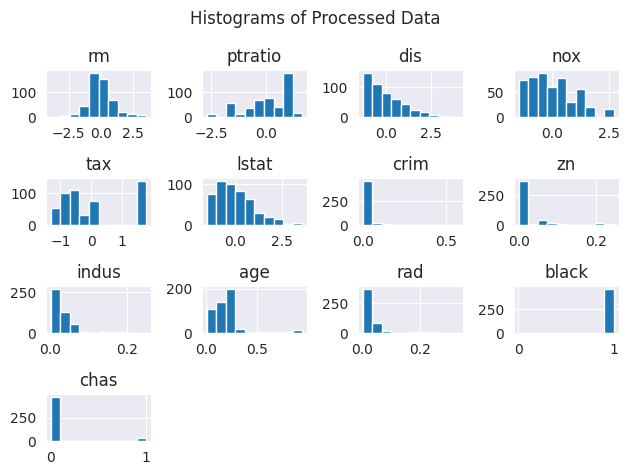

In [64]:
all_features = features_to_standardize + features_to_normalize + ['chas']

# Convert X_processed back to a DataFrame
X_processed = DataFrame(X_processed, columns=all_features)
X_processed.hist()
plt.suptitle("Histograms of Processed Data")
plt.tight_layout()
plt.show()

               rm   ptratio       dis       nox       tax     lstat      crim  \
rm       1.000000 -0.355501  0.205246 -0.302188 -0.292048 -0.613808 -0.167682   
ptratio -0.355501  1.000000 -0.232471  0.188933  0.460853  0.374044  0.239932   
dis      0.205246 -0.232471  1.000000 -0.769230 -0.534432 -0.496996 -0.301191   
nox     -0.302188  0.188933 -0.769230  1.000000  0.668023  0.590879  0.329051   
tax     -0.292048  0.460853 -0.534432  0.668023  1.000000  0.543993  0.476945   
lstat   -0.613808  0.374044 -0.496996  0.590879  0.543993  1.000000  0.372586   
crim    -0.167682  0.239932 -0.301191  0.329051  0.476945  0.372586  1.000000   
zn       0.310664 -0.392270  0.669000 -0.518360 -0.314757 -0.412822 -0.160441   
indus   -0.236454  0.297331 -0.498208  0.578670  0.623161  0.504321  0.636268   
age     -0.167547  0.252975 -0.502044  0.556711  0.535171  0.508832  0.648392   
rad     -0.138524  0.346488 -0.373426  0.455850  0.678546  0.428482  0.697182   
black    0.077473 -0.190044 

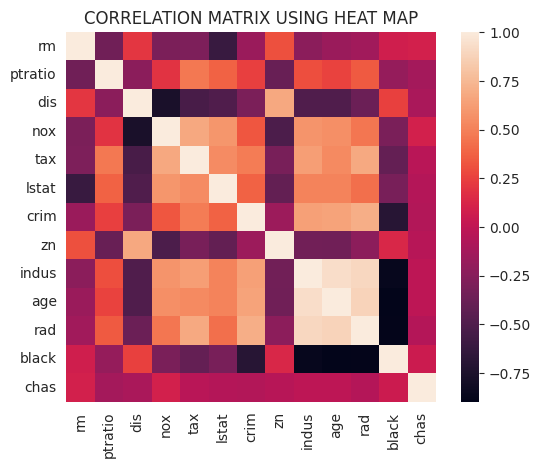

<Figure size 640x480 with 0 Axes>

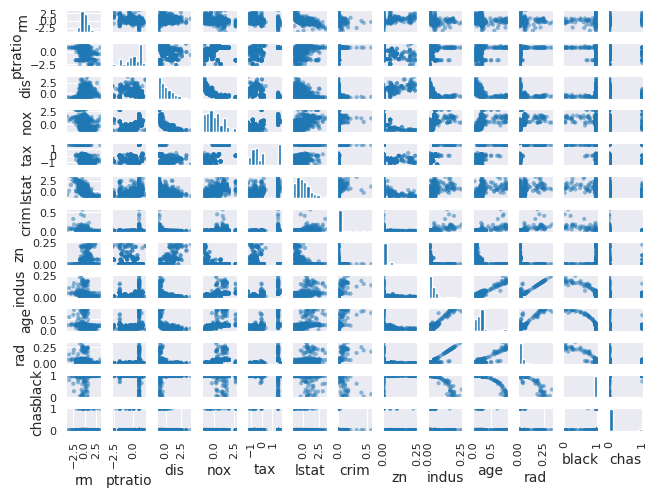

In [65]:
plt.figure() # new plot
#plt.tight_layout()
corMat = X_processed.corr(method='pearson')
print(corMat)
## plot correlation matrix as a heat map
sns.heatmap(corMat, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title(f"CORRELATION MATRIX USING HEAT MAP")
plt.show()

## scatter plot of all data
plt.figure()
# # The output overlaps itself, resize it to display better (w padding)
scatter_matrix(X_processed)
plt.tight_layout(pad=0.1)
plt.show()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

range(1, 14)
Num Features: 1
Selected Features: [False False False False False False False False  True False False False
 False]
Feature Ranking: [ 4 11 10 12 13  6  3  7  1  8  2  9  5]
Num Features: 2
Selected Features: [False False False False False False False False  True False  True False
 False]
Feature Ranking: [ 3 10  9 11 12  5  2  6  1  7  1  8  4]
Num Features: 3
Selected Features: [False False False False False False  True False  True False  True False
 False]
Feature Ranking: [ 2  9  8 10 11  4  1  5  1  6  1  7  3]
Num Features: 4
Selected Features: [ True False False False False False  True False  True False  True False
 False]
Feature Ranking: [ 1  8  7  9 10  3  1  4  1  5  1  6  2]
Num Features: 5
Selected Features: [ True False False False False False  True False  True False  True False
  True]
Feature Ranking: [1 7 6 8 9 2 1 3 1 4 1 5 1]
Num Features: 6
Selected Features: [ True False False False False  True  True False  True False  True False
  True]
Feature Rankin

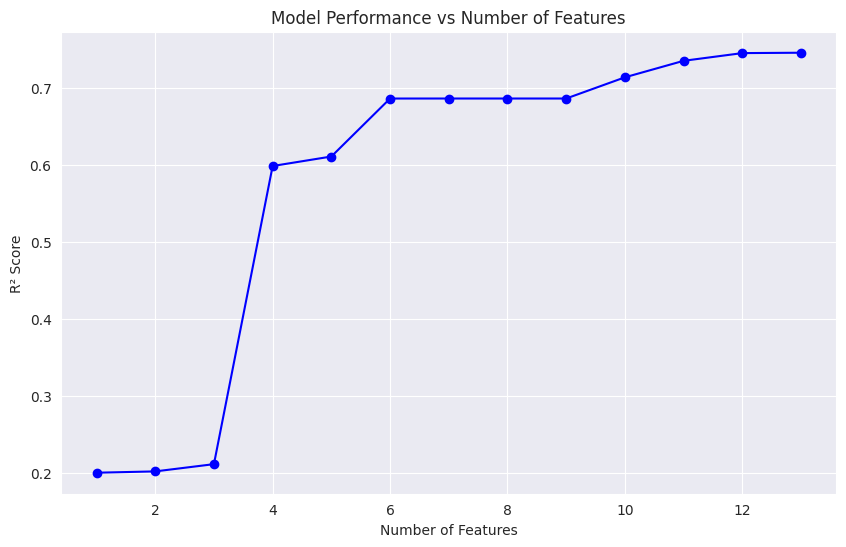

Optimal number of features: 13
Best score: 0.7460
Features selected: Index(['rm', 'ptratio', 'dis', 'nox', 'tax', 'lstat', 'crim', 'zn', 'indus',
       'age', 'rad', 'black', 'chas'],
      dtype='object')


In [67]:
def determine_optimal_number_of_features(X, y):
    feature_counts = range(1, X.shape[1] + 1)
    scores = []
    print(feature_counts)
    for num_features in feature_counts:
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select = num_features)
        fit = rfe.fit(X, y)
        print("Num Features:", fit.n_features_)
        print("Selected Features:", fit.support_)
        print("Feature Ranking:", fit.ranking_)
        scores.append(rfe.score(X,y))
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, scores, 'b-', marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('R² Score')
    plt.title('Model Performance vs Number of Features')
    plt.grid(True)
    plt.show()
    best_num_features = feature_counts[argmax(scores)]
    print(f"Optimal number of features: {best_num_features}")
    print(f"Best score: {max(scores):.4f}")
    print(f"Features selected: {X.columns[fit.support_]}")
    return feature_counts, scores

feature_counts, scores = determine_optimal_number_of_features(X_train, y_train)

In [68]:
def determine_features_within_threshold(_feature_counts, _scores):
    best_score = max(_scores)
    best_score_index = argmax(_scores)
    threshold = best_score * 0.98
    best_num_features = _feature_counts[best_score_index]
    i = best_score_index
    for i in range(best_score_index, 0, -1):
        if _scores[i] < threshold:
            print(f"Lowest number of features within 1% of best score: {_feature_counts[i]}")
            break
print("Raw Data")
determine_features_within_threshold(feature_counts, scores)

Raw Data
Lowest number of features within 1% of best score: 10


In [69]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
        """ Perform a forward-backward feature selection
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

In [70]:
result = stepwise_selection(X_train, y_train)

Add  lstat                          with p-value 3.19774e-70
Add  rm                             with p-value 3.26237e-25
Add  ptratio                        with p-value 3.70851e-11
Add  black                          with p-value 1.28801e-05
Add  dis                            with p-value 2.99151e-06
Add  nox                            with p-value 1.0268e-05
Add  chas                           with p-value 0.000880151


## Build a multiple linear regression model using the RFE and the stepwise methods.

In [71]:
# Build a multiple linear regression model using the RFE and the stepwise methods.
# RFE
rfe_model = LinearRegression()
rfe = RFE(rfe_model, n_features_to_select=8)
fit = rfe.fit(X_train, y_train)
selected_columns = X_train.columns[fit.support_]
X_train_rfe = X_train[selected_columns]
rfe_model.fit(X_train_rfe, y_train)
print("Num Features:", fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

# Stepwise
step_model = LinearRegression()
# Build a model using the selected features in result
X_train_step = X_train[result]
step_model.fit(X_train_step, y_train)
print("Num Features:", len(result))
print("Selected Features:", result)
print("Feature Ranking:", [X_train.columns.get_loc(x) for x in result])

# Compare the two models across the training and test sets
def compare_models(model1, model2, X_test_rfe, X_test_step, y_test):
    # Calculate R² score for both models
    r2_score1 = model1.score(X_test_rfe, y_test)
    r2_score2 = model2.score(X_test_step, y_test)

    print(f"RFE Model R² Score: {r2_score1:.4f}")
    print(f"Stepwise Model R² Score: {r2_score2:.4f}")

# Prepare test data with the correct features for each model
X_test_rfe = X_test[selected_columns]  # Only use columns selected by RFE
X_test_step = X_test[result]           # Only use columns selected by stepwise

# Compare models with appropriate test data
compare_models(rfe_model, step_model, X_test_rfe, X_test_step, y_test)

Num Features: 8
Selected Features: [ True False False False False  True  True  True  True  True  True False
  True]
Feature Ranking: [1 4 3 5 6 1 1 1 1 1 1 2 1]
Num Features: 7
Selected Features: ['lstat', 'rm', 'ptratio', 'black', 'dis', 'nox', 'chas']
Feature Ranking: [5, 0, 1, 11, 2, 3, 12]
RFE Model R² Score: 0.5572
Stepwise Model R² Score: 0.6359


Use the Boston dataset and design a regression model using MLP regressor.

Compare the results with MLR model using cross validation. (rerun with MLR)

Comment on the MLP regressor architecture and its relationship with overfitting.

In [72]:
# Set random seeds for reproducibility
tf.keras.backend.clear_session()
random.seed(42)
tf.random.set_seed(42)
data = read_csv(filename)
data = data.drop('index', axis=1)
X = data.drop('medv', axis=1)
y = data['medv']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [73]:
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))
#hidden1 = tf.keras.layers.Dense(64, activation="relu")(input_layer)
hidden2 = tf.keras.layers.Dense(32, activation="relu")(input_layer)#hidden1)
output = tf.keras.layers.Dense(1)(hidden2)  # No activation for regression
model = tf.keras.models.Model(inputs=[input_layer], outputs=[output])
model.compile(
    loss="mean_squared_error",
    optimizer="sgd",  # Using SGD like in the FashionMNIST example
    metrics=["mae"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = model.fit(
    X_train, y_train,
    #epochs=100,  # Adjusted based on the later results and the output of 100 epochs showing diminishing returns
    epochs=50,
    validation_data=(X_valid, y_valid),
    verbose=1
)

Epoch 1/50


/home/tr/cmpe188/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 13))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 325.9324 - mae: 15.1719 

/home/tr/cmpe188/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 13))
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 314.2871 - mae: 14.7771 - val_loss: 40.7592 - val_mae: 4.6989
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.2760 - mae: 3.6545 - val_loss: 30.2076 - val_mae: 3.8307
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.5750 - mae: 3.1729 - val_loss: 27.2252 - val_mae: 3.6331
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.2349 - mae: 2.9953 - val_loss: 25.4886 - val_mae: 3.4890
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.8138 - mae: 2.8470 - val_loss: 25.4277 - val_mae: 3.4727
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.2545 - mae: 2.7907 - val_loss: 24.4765 - val_mae: 3.4242
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.6207 - mae: 2.7111 - val_loss: 23.4748 - val_mae: 3.3776
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9623 - mae: 2.6345 - val_loss: 23.4204 - val_mae: 3.4236
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.879

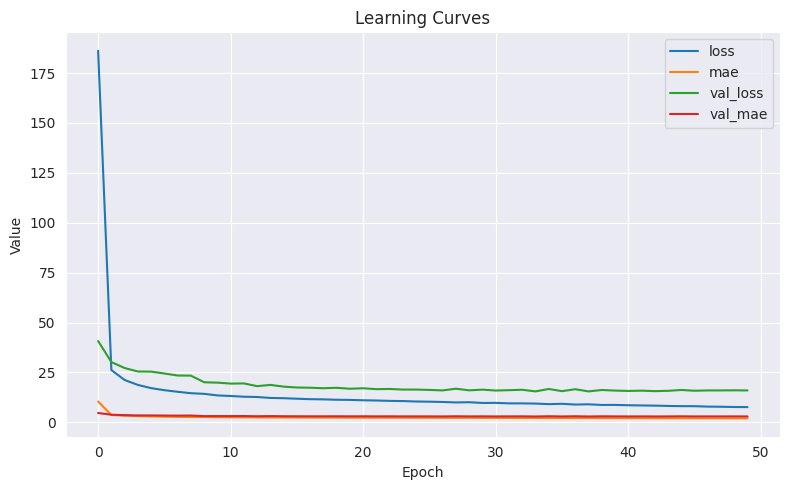

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 11.6932 - mae: 2.5617
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MLP Test MSE: 15.1728
MLP Test MAE: 2.7320
MLP Test R²: 0.7931
Linear Regression Test MSE: 25.1021
Linear Regression Test R²: 0.6577


/home/tr/cmpe188/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 13))
  warnings.warn(msg)
/home/tr/cmpe188/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 13))
  warnings.warn(msg)


In [75]:
# Plot learning curves
DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test).flatten()
mlp_mse = mean_squared_error(y_test, y_pred)
mlp_r2 = r2_score(y_test, y_pred)

print(f"MLP Test MSE: {mlp_mse:.4f}")
print(f"MLP Test MAE: {test_mae:.4f}")
print(f"MLP Test R²: {mlp_r2:.4f}")

# Compare with Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Test MSE: {lr_mse:.4f}")
print(f"Linear Regression Test R²: {lr_r2:.4f}")

First layer weights shape: (13, 32)
First layer biases shape: (32,)


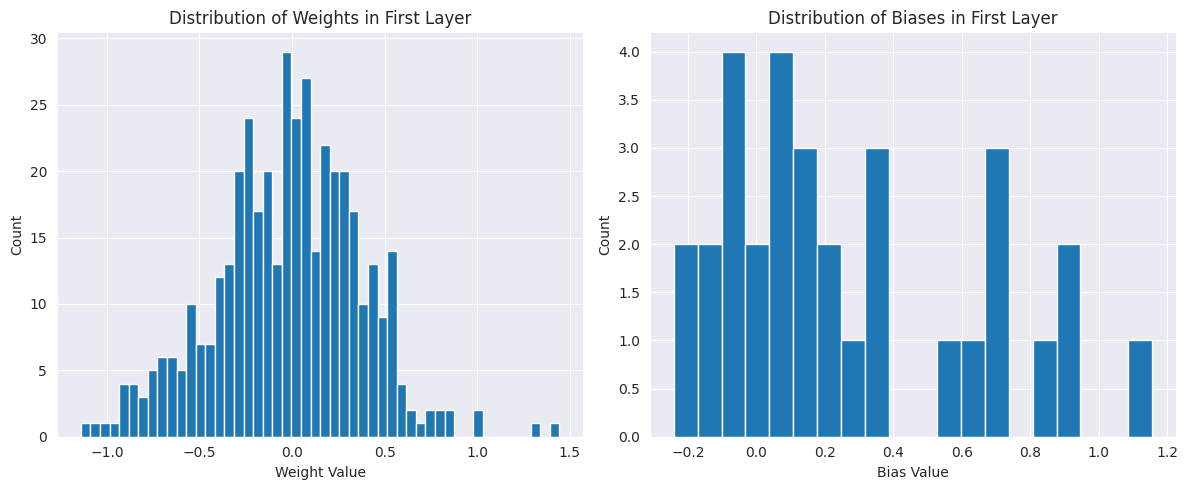

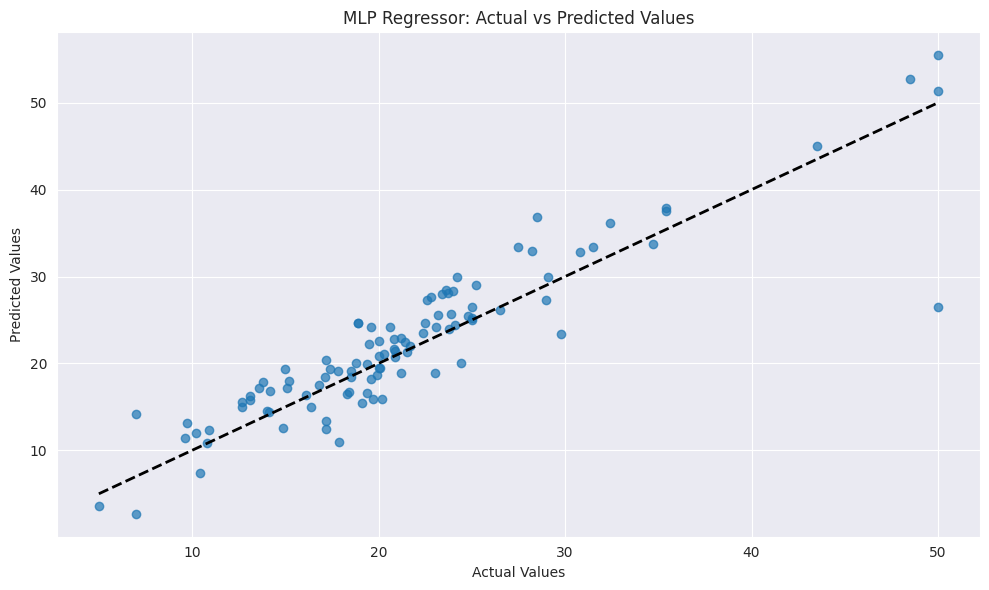

In [76]:
weights, biases = model.layers[1].get_weights()
print("First layer weights shape:", weights.shape)
print("First layer biases shape:", biases.shape)

# Plot the first few weights to visualize what the model learned
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights.flatten(), bins=50)
plt.title("Distribution of Weights in First Layer")
plt.xlabel("Weight Value")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(biases, bins=20)
plt.title("Distribution of Biases in First Layer")
plt.xlabel("Bias Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("MLP Regressor: Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

Testing architecture: [16]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Testing architecture: [32]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Testing architecture: [64]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Testing architecture: [128]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Testing architecture: [256]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Testing architecture: [32, 16]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Testing architecture: [64, 32]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Testing architecture: [128, 64]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Testing architecture: [64, 32, 16]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Results comparison:
   architecture        mse       mae        r2
0          [16]  16.008886  2.759089  0.781698
1          [32]  14.743165  2.597432  0.798958
2          [64]  13.431238  2.572993  0.816848
3         [128]  14.013009  2.606454  0.808915
4         [256]  14.231684  2.650827  0.805933
5      [32, 16]  24.197676  3.389681  0.670034
6      [64, 32]  15.816716  2.646657  0.78

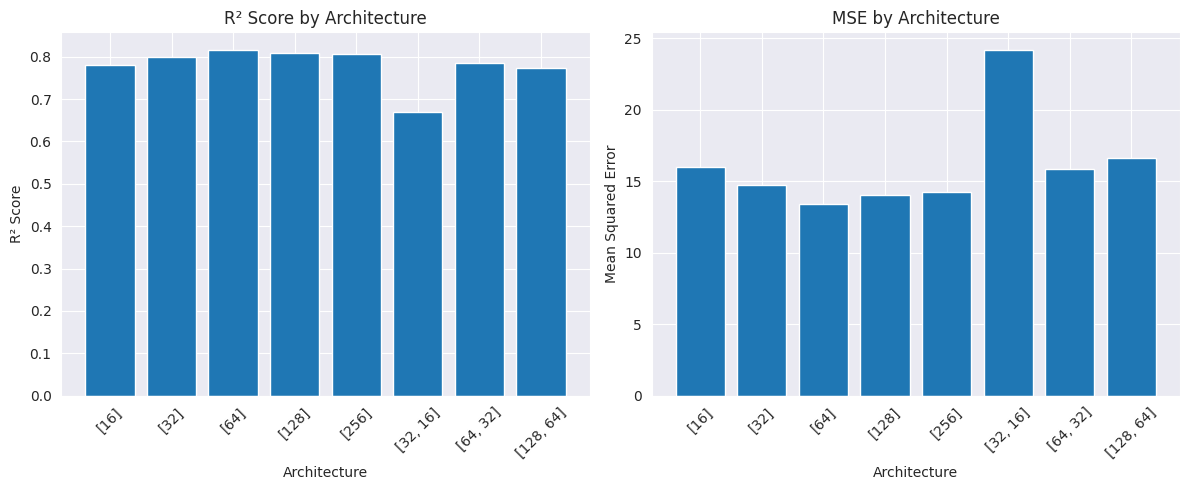


Performing cross-validation comparison...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
MLP Cross-Validation R² scores: [0.7939490778331915, 0.6335104058128705, 0.7862882487407328, nan, 0.8182149199237845]
MLP Cross-Validation Mean R²: 0.7580
Linear Regression Cross-Validation R² scores: [0.6687594935356319, 0.7342547033954023, 0.7098660061066442, 0.7759516773729642, 0.6872773137177993]
Linear Regression Cross-Validation Mean R²: 0.7152


In [77]:
def create_and_evaluate_model(hidden_units, X_train, y_train, X_valid, y_valid, X_test, y_test):
    tf.keras.backend.clear_session()

    # Input layer
    inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))
    x = inputs

    # Hidden layers
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation="relu")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)

    # Create and compile model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mean_squared_error", optimizer="sgd", metrics=["mae"])

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_valid, y_valid),
        verbose=0
    )

    # Evaluate - use try-except to handle potential NaN values
    try:
        _, mae = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test).flatten()

        # Check for NaN values and handle them
        if isnan(y_pred).any():
            print(f"Warning: NaN predictions found in architecture {hidden_units}")
            # Remove NaN values for metrics calculation
            mask = ~isnan(y_pred)
            if mask.sum() > 0:  # If we have any non-NaN values
                mse = mean_squared_error(y_test[mask], y_pred[mask])
                r2 = r2_score(y_test[mask], y_pred[mask])
            else:
                mse = nan
                r2 = nan
        else:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
    except Exception as e:
        print(f"Error evaluating model with architecture {hidden_units}: {e}")
        mae = nan
        mse = nan
        r2 = nan

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2,
        "history": history.history
    }

# Test multiple architectures
architectures = [
    [16],
    [32],
    [64],
    [128],
    [256],
    [32, 16],
    [64, 32],
    [128, 64],
    [64, 32, 16],
]

results = []
for arch in architectures:
    print(f"Testing architecture: {arch}")
    result = create_and_evaluate_model(arch, X_train, y_train, X_valid, y_valid, X_test, y_test)
    results.append({
        "architecture": str(arch),
        "mse": result["mse"],
        "mae": result["mae"],
        "r2": result["r2"]
    })

# Display results as a table
results_df = DataFrame(results)
print("\nResults comparison:")
print(results_df)

# Plot comparison - only include rows without NaN values
valid_results = results_df.dropna()
if len(valid_results) > 0:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(valid_results["architecture"], valid_results["r2"])
    plt.title("R² Score by Architecture")
    plt.xlabel("Architecture")
    plt.ylabel("R² Score")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(valid_results["architecture"], valid_results["mse"])
    plt.title("MSE by Architecture")
    plt.xlabel("Architecture")
    plt.ylabel("Mean Squared Error")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("No valid results to plot comparisons")

# Cross-validation comparison with Linear Regression
print("\nPerforming cross-validation comparison...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mlp_cv_scores = []
lr_cv_scores = []

for train_idx, val_idx in kf.split(X_scaled):
    # Get fold data
    X_fold_train, X_fold_val = X_scaled[train_idx], X_scaled[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train and evaluate MLP with best architecture
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(X_fold_train.shape[1],))
    x = tf.keras.layers.Dense(64, activation="relu")(inputs)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)

    fold_mlp = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    fold_mlp.compile(loss="mean_squared_error", optimizer="sgd")
    fold_mlp.fit(X_fold_train, y_fold_train, epochs=50, verbose=0)

    try:
        y_pred_fold_mlp = fold_mlp.predict(X_fold_val).flatten()
        # Check for NaN values
        if isnan(y_pred_fold_mlp).any():
            print("Warning: NaN values in MLP predictions for this fold")
            # Use only non-NaN predictions
            mask = ~isnan(y_pred_fold_mlp)
            if mask.sum() > 0:
                mlp_cv_scores.append(r2_score(y_fold_val.iloc[mask], y_pred_fold_mlp[mask]))
            else:
                mlp_cv_scores.append(nan)
        else:
            mlp_cv_scores.append(r2_score(y_fold_val, y_pred_fold_mlp))
    except Exception as e:
        print(f"Error in MLP cross-validation: {e}")
        mlp_cv_scores.append(nan)

    # Train and evaluate Linear Regression
    lr = LinearRegression()
    lr.fit(X_fold_train, y_fold_train)
    y_pred_fold_lr = lr.predict(X_fold_val)
    lr_cv_scores.append(r2_score(y_fold_val, y_pred_fold_lr))

# Filter out NaN scores
mlp_cv_scores_filtered = [score for score in mlp_cv_scores if not isnan(score)]

if mlp_cv_scores_filtered:
    print(f"MLP Cross-Validation R² scores: {mlp_cv_scores}")
    print(f"MLP Cross-Validation Mean R²: {mean(mlp_cv_scores_filtered):.4f}")
else:
    print(f"MLP Cross-Validation R² scores: {mlp_cv_scores}")
    print("No valid MLP cross-validation scores")

print(f"Linear Regression Cross-Validation R² scores: {lr_cv_scores}")
print(f"Linear Regression Cross-Validation Mean R²: {mean(lr_cv_scores):.4f}")